# Geometric Computer Vision: Final Project
This notebook contains a revisited implementation of the paper: **Shape Non-rigid Kinematics (SNK): A Zero-Shot Method for Non-Rigid Shape Matching via Unsupervised Functional Map Regularized Reconstruction** by Attaiki and Ovsjanikov (2024).

## Imports

In [1]:
from pyFM.functional import FunctionalMapping
import numpy as np
import trimesh
from pyFM.mesh import TriMesh
import torch
from torch_geometric.data import Batch
from diffusion_net import DiffusionData, DiffusionOperatorsTransform, DiffusionNet
from prism_decoder import PrismDecoder
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
from loss import PrismRegularizationLoss

## Load meshes
Let's first load the meshes of two dogs modified (non-rigid deformation using Blender):

In [3]:
# load some meshes
obj1 = r"./Samples/dog_small.obj"
obj2 = r"./Samples/dog_small_after_torture.obj"
mesh1, mesh2 = TriMesh(obj1), TriMesh(obj2)

## Compute correspondance from mesh2 to mesh1 using functional maps
I chose the pyFM package investigated in HW3 to compute a correspondance map between the meshes, using WKS descriptors:

In [4]:
process_params = {
    'n_ev': (70, 70),  # Number of eigenvalues on source and Target
    'subsample_step': 20,  # In order not to use too many descriptors
    'descr_type': 'WKS',  # WKS or HKS
}           
model = FunctionalMapping(mesh1, mesh2)
model.preprocess(**process_params, verbose=False)
fit_params = {
    'w_descr': 1e0,
    'w_lap': 1e-2,
    'w_dcomm': 1e-1,
    'w_orient': 0
}
model.fit(**fit_params, verbose=False)
p2p_21 = model.get_p2p(n_jobs=1)

## Visualization using meshplot package

In [5]:
import meshplot as mp

def double_plot_mp(myMesh1,myMesh2,cmap1=None,cmap2=None):
    p = mp.plot(myMesh1.vertlist, myMesh1.facelist, c=cmap1)
    v2_translated = myMesh2.vertlist.copy()
    f2_translated = myMesh2.facelist.copy()
    myMesh2_translated = TriMesh(v2_translated, f2_translated)
    myMesh2_translated.vertlist[:,0] = myMesh2_translated.vertlist[:,0] + 30 
    p.add_mesh(myMesh2_translated.vertlist, myMesh2_translated.facelist, c=cmap2)
    
def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21]
double_plot_mp(mesh1,mesh2,cmap1,cmap2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0212688…

## Compute latent vector
Following section 4.2 in the paper, we compute a latent vector (of length d1) per feature using DiffusionNet++ module, then apply max pooling to get a vector l of length d1.

Then we aim to reconstruct the first shape by concatenating l to each feature of the second mesh and passing those to the decoder. 

In [6]:
def compute_l(my_batch, diffusion_net):
    my_batch.x = my_batch.pos.clone()  # set the input features to the positions
    output = diffusion_net(my_batch)
    l = output.x.max(dim=0).values
    return l
    
def reconstruct_s2(my_batch2, v2_t, l, decoder):
    l_expanded = l.unsqueeze(0).repeat(v2_t.shape[0],1)
    my_batch2.x = torch.cat((v2_t,l_expanded),dim=1) #.unsqueeze(0)
    # my_batch2.pos = my_batch2.pos.unsqueeze(0) #my_batch2.pos.clone()   .clone() # set the input features to the positions
    s3 = decoder(my_batch2)
    return s3

Prepare first mesh for compatibility with DiffusionNet++ model

In [36]:
mesh1_diff = trimesh.load(obj1)
v1, f1 = np.array(mesh1.vertices), np.array(mesh1.faces)
v1_t = torch.from_numpy(v1)
f1_t = torch.from_numpy(f1)
data1 = DiffusionData(pos=v1_t, face=f1_t.T)
diffusion_transform = DiffusionOperatorsTransform(n_eig=50)  #97 compute the diffusion net operators with 97 eigenvalues
data1 = diffusion_transform(data1)
my_batch = Batch.from_data_list([data1])

Prepare second mesh for compatibility with DiffusionNet++ model

In [37]:
mesh2_diff = trimesh.load(obj2)
v2, f2 = np.array(mesh2.vertices), np.array(mesh2.faces)
data2 = DiffusionData(pos=torch.from_numpy(v2), face=torch.from_numpy(f2).T)
diffusion_transform = DiffusionOperatorsTransform(n_eig=50)  #97 compute the diffusion net operators with 97 eigenvalues
data2 = diffusion_transform(data2)
my_batch2 = Batch.from_data_list([data2])
my_batch2.pos = my_batch2.pos.unsqueeze(0) 
#######
v2_t = torch.Tensor(v2)

Make parameters differentiable - for backward propagation

In [38]:
my_batch.pos.requires_grad = True
v2_t.requires_grad = True
my_batch2.pos.requires_grad = True

## Prepare visualization functions

In [39]:
def double_plot(myMesh1, myMesh2, cmap1=None, cmap2=None, title1='Mesh1',title2='Mesh2'):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_trisurf(myMesh1.vertlist[:, 0], myMesh1.vertlist[:, 1], myMesh1.vertlist[:, 2],
                     triangles=myMesh1.facelist, cmap='viridis', facecolors=cmap1)
    ax1.set_title(title1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_trisurf(myMesh2.vertlist[:, 0], myMesh2.vertlist[:, 1], myMesh2.vertlist[:, 2],
                     triangles=myMesh2.facelist, cmap='viridis', facecolors=cmap2)
    ax2.set_title(title2)

def visu_face_colors(s1_faces_raw, s1_faces, s2_faces, s3_faces):
    cmap = cm.get_cmap('viridis', s3_faces.shape[0])  # Use a colormap with 500 distinct colors
    face_colors = cmap(np.linspace(0, 1, s3_faces.shape[0]))
    
    average_z = np.mean(s2_faces[:, :, 2], axis=1)
    sorted_indices = np.argsort(average_z)
    
    sorted_s3_faces = s3_faces[sorted_indices]
    sorted_s2_faces = s2_faces[sorted_indices]
    sorted_s1_faces = s1_faces[sorted_indices]
    fig = plt.figure()
    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')
    for i, face in enumerate(s3_faces):
        # poly3d = [[vertices[vert_idx] for vert_idx in face]]
        poly3d_1 = [sorted_s1_faces[i]]
        poly3d_2 = [sorted_s2_faces[i]]
        poly3d_1_raw = [s1_faces_raw[i]]
        poly3d_3 = [sorted_s3_faces[i]]
        ax1.add_collection3d(Poly3DCollection(poly3d_1, facecolors=face_colors[i], linewidths=1, edgecolors=None, alpha=.8))
        ax1.add_collection3d(Poly3DCollection(poly3d_1_raw, facecolors='b', linewidths=1, edgecolors=None, alpha=.1))
        ax2.add_collection3d(Poly3DCollection(poly3d_2, facecolors=face_colors[i], linewidths=1, edgecolors=None, alpha=.8))
        ax3.add_collection3d(Poly3DCollection(poly3d_3, facecolors=face_colors[i], linewidths=1, edgecolors=None, alpha=.8))
    ax1.set_xlim([s1_faces[:,:,0].min(), s1_faces[:,:,0].max()])
    ax1.set_ylim([s1_faces[:,:,1].min(), s1_faces[:,:,1].max()])
    ax1.set_zlim([s1_faces[:,:,2].min(), s1_faces[:,:,2].max()])
    ax2.set_xlim([s2_faces[:,:,0].min(), s2_faces[:,:,0].max()])
    ax2.set_ylim([s2_faces[:,:,1].min(), s2_faces[:,:,1].max()])
    ax2.set_zlim([s2_faces[:,:,2].min(), s2_faces[:,:,2].max()])
    ax3.set_xlim([s3_faces[:,:,0].min(), s3_faces[:,:,0].max()])
    ax3.set_ylim([s3_faces[:,:,1].min(), s3_faces[:,:,1].max()])
    ax3.set_zlim([s3_faces[:,:,2].min(), s3_faces[:,:,2].max()])
    plt.show()

## Handling face matching for visualization

In [40]:
def compute_centroid(face):
    return np.mean(face, axis=0)

def find_closest_faces(lf1, lf2):
    centroids_lf1 = np.array([compute_centroid(face) for face in lf1])
    centroids_lf2 = np.array([compute_centroid(face) for face in lf2])
    
    closest_faces = []
    closest_faces_idx = []
    
    for centroid in centroids_lf2:
        distances = np.linalg.norm(centroids_lf1 - centroid, axis=1)
        closest_face_idx = np.argmin(distances)
        while closest_face_idx in closest_faces_idx:
            distances[closest_face_idx] = max(distances) + 1
            closest_face_idx = np.argmin(distances)
        closest_faces.append(lf1[closest_face_idx])
        closest_faces_idx.append(closest_face_idx)
    return closest_faces_idx

In [41]:
v1s = my_batch.pos.reshape(-1, 3)
f1s = my_batch.face.t()
s1_faces_tmp = v1s[f1s].detach().numpy()

## Initialization of the models (DiffusionNet, PrismDecoder)

In [42]:
L_SPACE_SIZE = 42
diffusion_net = DiffusionNet(3, L_SPACE_SIZE)
decoder = PrismDecoder(v1.shape[1]+L_SPACE_SIZE, v1.shape[0])

## Training process

  0%|                                                                                                                                                                                   | 0/20000 [00:00<?, ?it/s]C:\Users\Hadassa-Port\AppData\Local\Temp\ipykernel_10644\1502401667.py:15: UserWarning: Using a target size (torch.Size([1, 487, 3])) that is different to the input size (torch.Size([487, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(torch.Tensor(v1_remapped),s3.features)
202.638992:   0%|                                                                                                                                                                       | 0/20000 [00:00<?, ?it/s]

Epoch 0: MSE loss = 202.6389923095703
Epoch 0: Energy loss = 15.216266632080078


C:\Users\Hadassa-Port\AppData\Local\Temp\ipykernel_10644\2963957283.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', s3_faces.shape[0])  # Use a colormap with 500 distinct colors


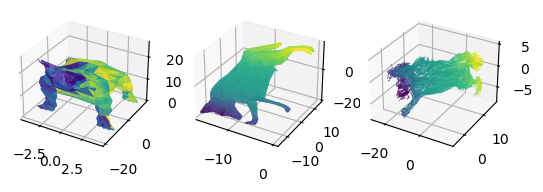

16.628716:   0%|▏                                                                                                                                                            | 20/20000 [00:56<6:03:20,  1.09s/it]

Epoch 20: MSE loss = 16.62871551513672
Epoch 20: Energy loss = 0.005449899006634951


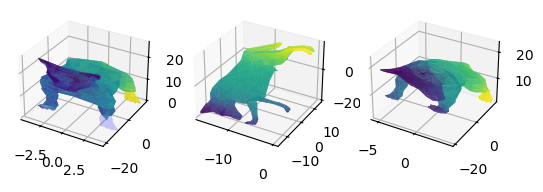

15.918887:   0%|▎                                                                                                                                                            | 40/20000 [01:26<5:31:19,  1.00it/s]

Epoch 40: MSE loss = 15.9188871383667
Epoch 40: Energy loss = 0.0022995322942733765


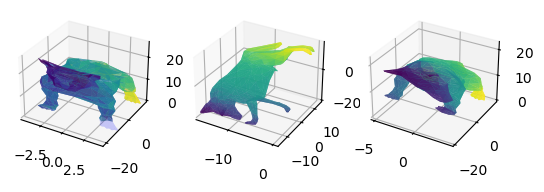

15.757990:   0%|▍                                                                                                                                                            | 60/20000 [01:56<6:20:54,  1.15s/it]

Epoch 60: MSE loss = 15.757989883422852
Epoch 60: Energy loss = 0.0025140426587313414


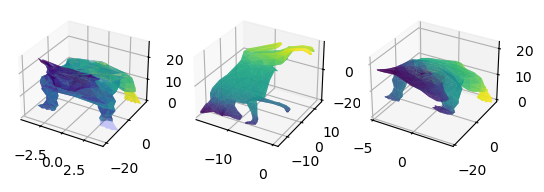

15.324884:   0%|▋                                                                                                                                                            | 80/20000 [02:25<5:26:02,  1.02it/s]

Epoch 80: MSE loss = 15.324884414672852
Epoch 80: Energy loss = 0.008879538625478745


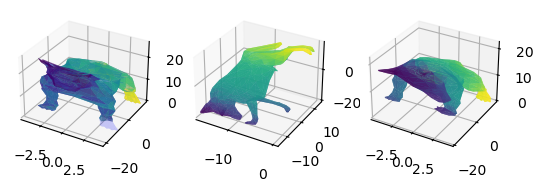

14.643659:   0%|▊                                                                                                                                                           | 100/20000 [02:54<5:27:12,  1.01it/s]

Epoch 100: MSE loss = 14.643658638000488
Epoch 100: Energy loss = 0.028586259111762047


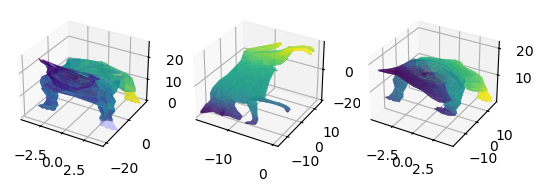

14.621171:   1%|▉                                                                                                                                                           | 120/20000 [03:24<5:38:06,  1.02s/it]

Epoch 120: MSE loss = 14.621170997619629
Epoch 120: Energy loss = 0.022592267021536827


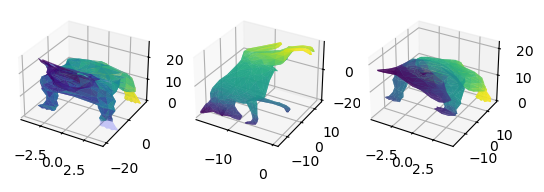

14.442004:   1%|█                                                                                                                                                           | 140/20000 [03:54<5:32:36,  1.00s/it]

Epoch 140: MSE loss = 14.442004203796387
Epoch 140: Energy loss = 0.028716232627630234


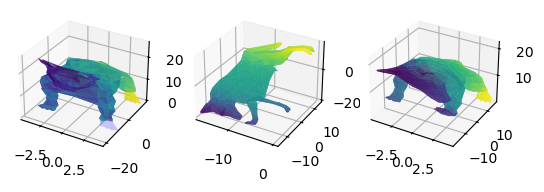

14.378405:   1%|█▏                                                                                                                                                          | 160/20000 [04:22<5:38:02,  1.02s/it]

Epoch 160: MSE loss = 14.37840461730957
Epoch 160: Energy loss = 0.0275796577334404


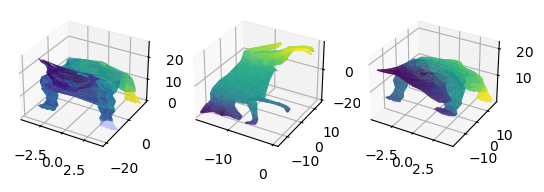

14.238372:   1%|█▍                                                                                                                                                          | 180/20000 [04:54<5:23:15,  1.02it/s]

Epoch 180: MSE loss = 14.238371849060059
Epoch 180: Energy loss = 0.032056499272584915


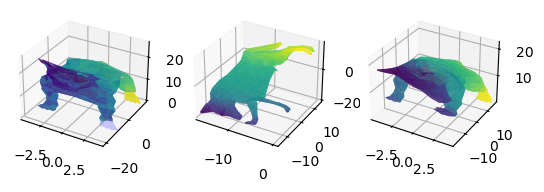

14.118521:   1%|█▌                                                                                                                                                          | 200/20000 [05:25<5:31:08,  1.00s/it]

Epoch 200: MSE loss = 14.118520736694336
Epoch 200: Energy loss = 0.03377411141991615


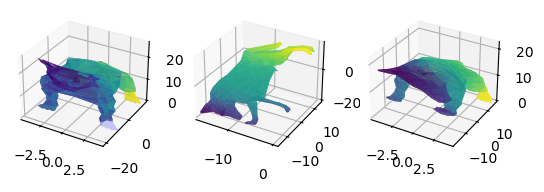

13.863821:   1%|█▋                                                                                                                                                          | 220/20000 [05:55<5:23:23,  1.02it/s]

Epoch 220: MSE loss = 13.863821029663086
Epoch 220: Energy loss = 0.03817048296332359


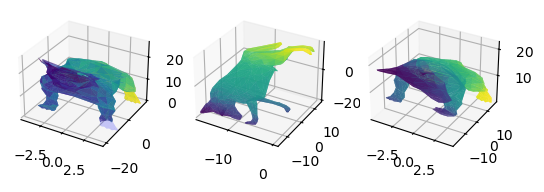

13.633908:   1%|█▊                                                                                                                                                          | 240/20000 [06:23<5:24:57,  1.01it/s]

Epoch 240: MSE loss = 13.63390827178955
Epoch 240: Energy loss = 0.04468155652284622


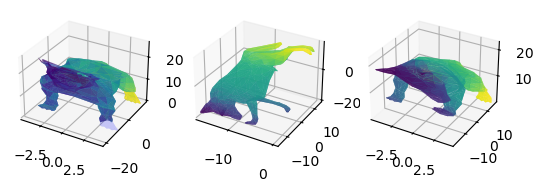

13.280424:   1%|██                                                                                                                                                          | 260/20000 [06:51<5:22:02,  1.02it/s]

Epoch 260: MSE loss = 13.280424118041992
Epoch 260: Energy loss = 0.0489220917224884


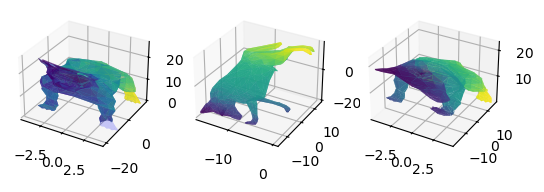

12.997102:   1%|██▏                                                                                                                                                         | 280/20000 [07:20<5:58:33,  1.09s/it]

Epoch 280: MSE loss = 12.997101783752441
Epoch 280: Energy loss = 0.05989930406212807


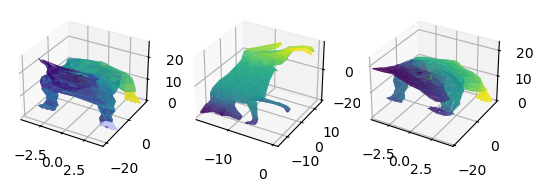

12.784688:   1%|██▎                                                                                                                                                         | 295/20000 [07:44<5:33:18,  1.01s/it]

In [ ]:
# %debug
lambda_E = 20
losses_MSE = []
losses_energy = []
losses = []
get_energy_loss = PrismRegularizationLoss(100)
optimizer_diffnet = optim.AdamW(diffusion_net.parameters() ,lr=0.001, weight_decay=0.001)
optimizer_decoder = optim.AdamW(decoder.parameters() ,lr=0.001, weight_decay=0.001)
for epoch in (pbar:=tqdm(range(20000))):
    l = compute_l(my_batch, diffusion_net)
    l.retain_grad()
    s3 = reconstruct_s2(my_batch2, v2_t, l, decoder)
    s3.features.retain_grad()
    v1_remapped = v1[p2p_21]
    loss = torch.nn.functional.mse_loss(torch.Tensor(v1_remapped),s3.features)
    loss_E = get_energy_loss(s3.transformed_prism, s3.rotations, s3.pos.reshape(-1, 3), s3.face) 
    total_loss = loss + loss_E*lambda_E
    losses_MSE.append(loss.detach())
    losses_energy.append(loss_E.detach())
    losses.append(total_loss.detach())
    pbar.set_description(f"{loss.detach():3f}")
    total_loss.retain_grad()
    total_loss.backward()
    # import ipdb; ipdb.set_trace()
    optimizer_diffnet.step()
    optimizer_diffnet.zero_grad()
    optimizer_decoder.step()
    optimizer_decoder.zero_grad()
    if epoch%20 == 0:
        print(f'Epoch {epoch}: MSE loss = {loss}')
        print(f'Epoch {epoch}: Energy loss = {loss_E}')
        verts = my_batch2.pos.reshape(-1, 3)
        faces = my_batch2.face.t()
        s2_faces = verts[faces].detach().numpy()
        s3_faces = s3.transformed_prism.detach().squeeze(0).numpy()
        closest_faces_idx = find_closest_faces(s1_faces_tmp, s3_faces) #find_closest_faces(s3_faces, s1_faces_tmp)
        s1_faces = s1_faces_tmp[closest_faces_idx]
        visu_face_colors(s1_faces_tmp, s1_faces, s2_faces, s3_faces)
        plt.show()

## Plot the loss functions

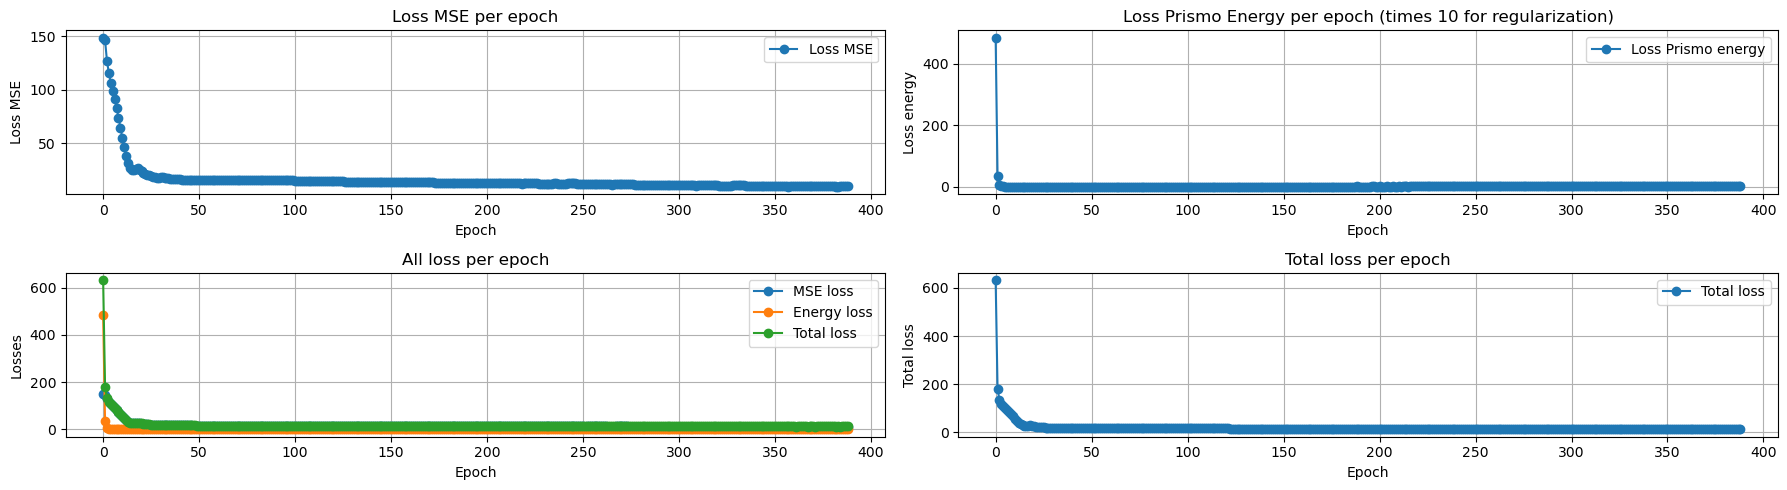

In [34]:
# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 5))
l_energy = [lambda_E*a for a in losses_energy]
# Plot MSE loss
axs[0,0].plot(range(len(losses_MSE)), losses_MSE, label='Loss MSE', marker='o')
axs[0,0].set_xlabel('Epoch'); axs[0,0].set_ylabel('Loss MSE')
axs[0,0].set_title('Loss MSE per epoch'); axs[0,0].legend(); axs[0,0].grid(True)

# Plot Energy loss
axs[0,1].plot(range(len(losses_energy)), l_energy, label='Loss Prismo energy', marker='o')
axs[0,1].set_xlabel('Epoch'); axs[0,1].set_ylabel('Loss energy')
axs[0,1].set_title(f'Loss Prismo Energy per epoch (times {lambda_E} for regularization)'); axs[0,1].legend(); axs[0,1].grid(True)

# Plot total loss
axs[1,0].plot(range(len(losses_MSE)), losses_MSE, label='MSE loss', marker='o')
axs[1,0].plot(range(len(l_energy)), l_energy, label='Energy loss', marker='o')
axs[1,0].plot(range(len(losses)), losses, label='Total loss', marker='o')
axs[1,0].set_xlabel('Epoch'); axs[1,0].set_ylabel('Losses')
axs[1,0].set_title('All loss per epoch'); axs[1,0].legend(); axs[1,0].grid(True)

# Plot total loss
axs[1,1].plot(range(len(losses)), losses, label='Total loss', marker='o')
axs[1,1].set_xlabel('Epoch'); axs[1,1].set_ylabel('Total loss')
axs[1,1].set_title('Total loss per epoch'); axs[1,1].legend(); axs[1,1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Save first shape (remapped based on functional map) and its reconstruction.

In [ ]:
np.save('shape1_baseline.npy', v1_remapped)
np.save('shape2_reconstruction.npy', s3.features.detach().squeeze(0).numpy())
